In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from prophet import Prophet
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

c:\Users\Morinyo Baddestman\Documents\Time_Series_Analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# import and show the data
df=pd.read_csv(r'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX032NEN/images/data/long_data_.csv')
df.head()

,States,Regions,latitude,longitude,Dates,Usage
0,Punjab,NR,31.519974,75.980003,02/01/2019 00:00:00,119.9
1,Haryana,NR,28.450006,77.019991,02/01/2019 00:00:00,130.3
2,Rajasthan,NR,26.449999,74.639981,02/01/2019 00:00:00,234.1
3,Delhi,NR,28.669993,77.230004,02/01/2019 00:00:00,85.8
4,UP,NR,27.599981,78.050006,02/01/2019 00:00:00,313.9


In [3]:
# dataframe features
print('dataframe is of shape\n', df.shape)
print(df.info())

dataframe is of shape
 (16599, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16599 entries, 0 to 16598
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   States     16599 non-null  object 
 1   Regions    16599 non-null  object 
 2   latitude   16599 non-null  float64
 3   longitude  16599 non-null  float64
 4   Dates      16599 non-null  object 
 5   Usage      16599 non-null  float64
dtypes: float64(3), object(3)
memory usage: 778.2+ KB
None


## data preprocessing 

In [4]:
# convert df columns to lower case for easier referrencing
df.columns = [col.lower() for col in df.columns]

# convert the dates column to date_time format
df['dates'] = pd.to_datetime(df['dates'], format='mixed', dayfirst= True)

# drop unneccesary columns
df = df.drop(['longitude', 'latitude'], axis=1)

In [5]:
# group the data by dates (using the average of all states usage per day)
df = df.groupby('dates', as_index=False).mean(numeric_only=True)
print('new shape\n', df.shape)
print(df.head())


new shape
 (498, 2)
       dates       usage
0 2019-01-02  102.224242
1 2019-01-03  103.142424
2 2019-01-04  100.124242
3 2019-01-05  100.269697
4 2019-01-06  100.512121


In [8]:
# visualize the average electricity usage per day 
fig = px.line(df, x='dates', y= 'usage', title='Average Electricity Usage per Day')
fig.show()

## Modelling

### Create the base model
i.e. a model with default hyperparameters to serve as the basis to improve the model

In [10]:
# rename columns to meet prophets specificaions
df.columns= ['ds', 'y']
df.head()


,ds,y
0,2019-01-02,102.224242
1,2019-01-03,103.142424
2,2019-01-04,100.124242
3,2019-01-05,100.269697
4,2019-01-06,100.512121


In [13]:
# initialize model class
model = Prophet()

# fit model
model.fit(df)

# print model components
model.component_modes

23:24:40 - cmdstanpy - INFO - Chain [1] start processing
23:24:40 - cmdstanpy - INFO - Chain [1] done processing


{'additive': ['weekly',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

In [ ]:
# make a future dataframe for which we make predictions
future_dates = model.make_future_dataframe(periods=365, # number of periods to forecast
                                        freq= 'd', # frequency = day
                                        include_history=True # include historical dates for prediction
                                        )

# show dataframe
future_dates.head()

,ds
0,2019-01-02
1,2019-01-03
2,2019-01-04
3,2019-01-05
4,2019-01-06


In [15]:
# predict using the future dates
prediction = model.predict(future_dates)

#show predictions
print(prediction.shape)
prediction.head()

(863, 16)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-02,101.808870,89.153505,114.112187,101.808870,101.808870,-0.127512,-0.127512,-0.127512,-0.127512,-0.127512,-0.127512,0.0,0.0,0.0,101.681359
1,2019-01-03,101.813825,88.622252,113.218656,101.813825,101.813825,-0.027117,-0.027117,-0.027117,-0.027117,-0.027117,-0.027117,0.0,0.0,0.0,101.786708
2,2019-01-04,101.818780,88.343315,114.385300,101.818780,101.818780,-0.073942,-0.073942,-0.073942,-0.073942,-0.073942,-0.073942,0.0,0.0,0.0,101.744839
3,2019-01-05,101.823736,89.673241,114.136956,101.823736,101.823736,-0.308206,-0.308206,-0.308206,-0.308206,-0.308206,-0.308206,0.0,0.0,0.0,101.515530
4,2019-01-06,101.828691,90.203762,114.061499,101.828691,101.828691,0.081510,0.081510,0.081510,0.081510,0.081510,0.081510,0.0,0.0,0.0,101.910201


C:\Users\Morinyo Baddestman\AppData\Local\Temp\ipykernel_4056\773271589.py:3: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



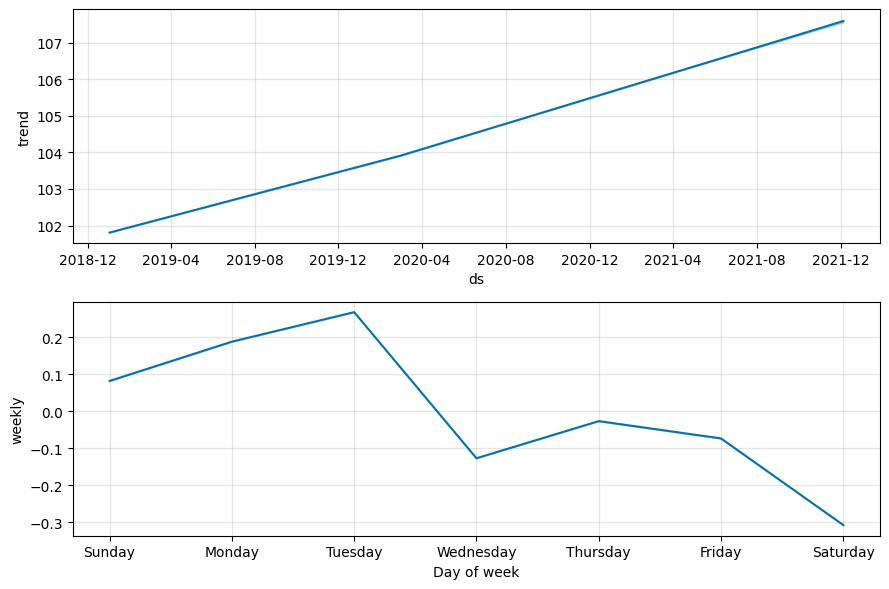

In [ ]:
# visualize the components of the model(the trend and weekly seasonalities to understand the data)
fig = model.plot_components(prediction)
fig.show()

yhat upper values and yhat lower values represent the Uncertainity Interval

There are three sources of uncertainty in the forecast:

- uncertainty in the trend.
- uncertainty in the seasonality estimates.
- additional observation noise.

Visualize these uncertainities together with the predictions to have a visual sense of the forecast using scatter trace

In [ ]:
# plot the predictions and the optimazations using scatter trace
trace_open = go.Scatter(
    x = prediction["ds"],
    y = prediction["yhat"],
    mode = 'lines',
    name="Forecast"
)
trace_high = go.Scatter(
    x = prediction["ds"],
    y = prediction["yhat_upper"],
    mode = 'lines',
    fill = "tonexty", 
    line = {"color": "#57b8ff"}, 
    name="Higher uncertainty interval"
)
trace_low = go.Scatter(
    x = prediction["ds"],
    y = prediction["yhat_lower"],
    mode = 'lines',
    fill = "tonexty", 
    line = {"color": "#57b8ff"}, 
    name="Lower uncertainty interval"
)
trace_close = go.Scatter(
    x = df["ds"],
    y = df["y"],
    name="Data values"
)

#make list for all three scattle objects.
data = [trace_open,trace_high,trace_low,trace_close]

# Construct a new Layout object. 
layout = go.Layout(title="Power consumption forecasting")

fig = go.Figure(data=data)
fig.show()

plot the actual vs predicted values without optimization

In [ ]:
fig = go.Figure([go.Scatter(x=df['ds'], y=df['y'],mode='lines',
                    name='Actual')])


fig.add_trace(go.Scatter(x=prediction['ds'], y=prediction['yhat'],
                   mode='lines+markers',
                    name='predicted'))

fig.show()

In [22]:
# mean absolute error
#Return a Numpy representation of the DataFrame.
y_true = df['y'].values

#Here we have specified [:498] because in y_true we have 498 data points so for comparing both series we need equal shape of series.
y_pred = prediction['yhat'][:498].values 


mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

MAE: 7.904


### optimizing the model for better perfomamnce

In [23]:
# initialize and tune hyperparameters
model1=Prophet(daily_seasonality=True).add_seasonality(name='yearly',
                                                       period=365,
                                                       fourier_order=70)

# fit the model to the data 
model1.fit(df)

#print model components
model1.component_modes

23:51:38 - cmdstanpy - INFO - Chain [1] start processing
23:51:38 - cmdstanpy - INFO - Chain [1] done processing


{'additive': ['yearly',
  'weekly',
  'daily',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

In [24]:
# make future dataframe
future_dates1=model1.make_future_dataframe(periods=365)

prediction1=model1.predict(future_dates1)

C:\Users\Morinyo Baddestman\AppData\Local\Temp\ipykernel_4056\2761334639.py:3: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



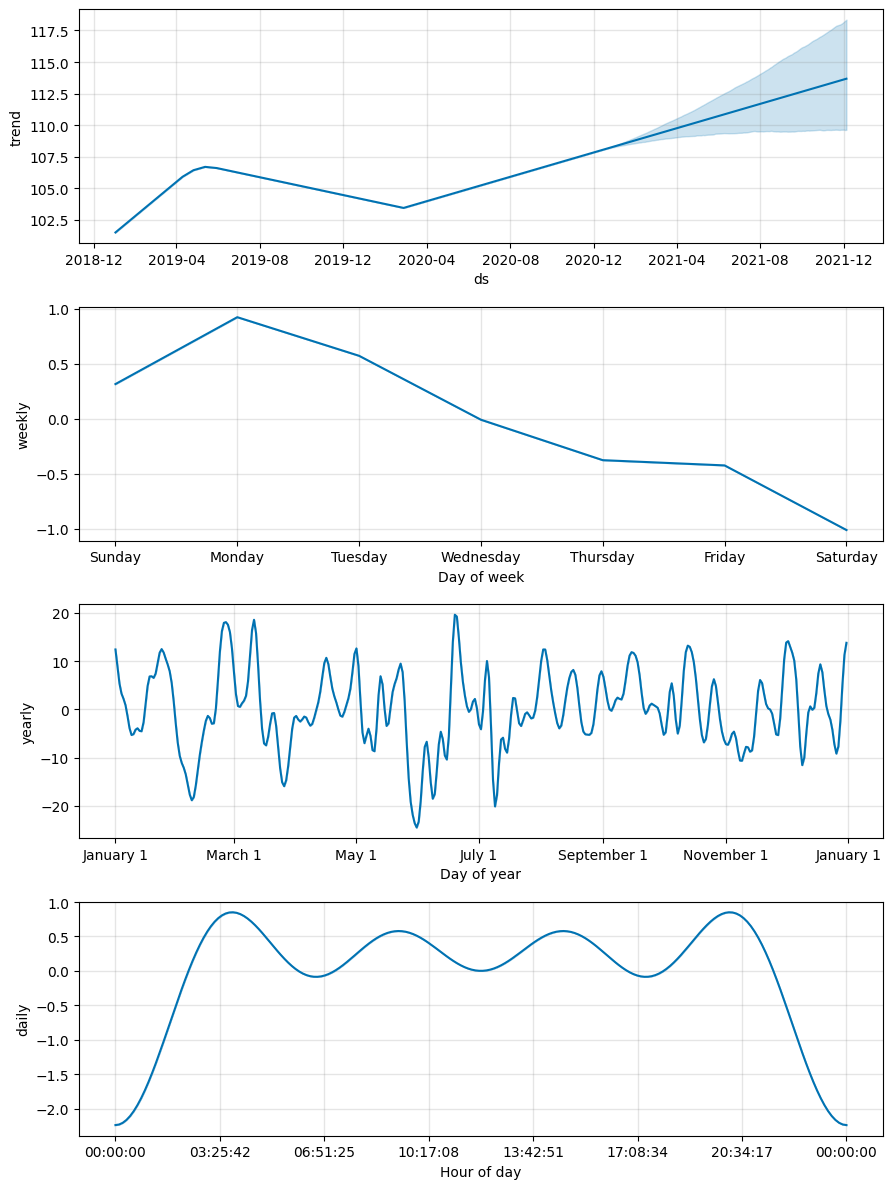

In [25]:
# plot the model components
fig = model1.plot_components(prediction1)
fig.show()

In [ ]:
# evaluate the models perfomance
y_true = df['y'].values
y_pred = prediction1['yhat'][:498].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

MAE: 4.020


On tuning the model hyperparameters the model shows some improvemets in the mean absolute error metric

In [ ]:
# plot the predicted values against the actual values
fig = go.Figure([go.Scatter(x=df['ds'], y=df['y'],mode='lines',
                    name='Actual')])

fig.add_trace(go.Scatter(x=prediction1['ds'], y=prediction1['yhat'],
                   mode='lines+markers',
                    name='predicted'))

fig.show()